# Cancer Mortality Exploration

Zeliang (Doug) Xu, Arjun Chakraborty, John Boudreaux

_An exploratory analysis of county characteristics as they relate to cancer death rates_

## Introduction
This exploratory analysis is meant to address the research question: 

__What factors are related to the cancer death rate in US counties?__

By looking at the dataset and our general intuition about cancer, we believe that there are two major sources of contributing factors that lead to higher cancer death rate for each physical region:

* Higher cancer occurance rates will lead to more cases of cancer deaths in a particular region
* Worse cancer treatment facilities, policies, personnel, etc. will lead to more cancer deaths in a particular region

To explore this research question and sub-topics, we will employ various statistical techniques including subsetting the data, descriptive statistics, outlier detection and treatment, multivariate correlations, and others. In particular, our analysis will focus heavily on using graphical methods to illustrate various aspects about our dataset. We find certain relationships, particularly in the area of insurance coverage, that prove interesting as levers for policy change.

It is important to note that our analysis is not meant to prove any sort of causality. All of our methods and conclusions are purely meant as descriptive methods to explore the relationships within the data. Additionally, this dataset has some very particular issues that indicate further data collection or clarification may be necessary to fully validate the results. For instance, there is no documentation on the basis of the death rate- is this a death rate per 100,000 people, averaged over some period? Is it normalized in any way? Is it only deaths from cancer? Without further documentation, we can still perform some analysis but still need to clarify some assumptions before action can be responsibly taken.

In this report, we will use R (>=3.4) to perform the analysis. We will provide code for all graphics and analysis performed so that the reader can reproduce this analysis with the given dataset.

## Data Preparation

Below is a collection of libraries that we use for the study:

In [18]:
library(car)   # to enable csv import, plots functions
library(stringr)   # to enable string splitting
library(corrplot)   # to enable corrplot
library(data.table)   # to be able to change the indexing of data frame
options(repr.plot.width=5, repr.plot.height=4) # formatting for reasonable plot size

In [19]:
#may need to change address depending on where you have it saved
data <- read.csv("../project materials/cancer.csv")

In [20]:
dim(data)

[1] 3047   30

Our data has 3047 observations of 30 variables. These dimensions ought to be sufficient for many subsetting operations we may want to do with the data. The variables all describe different properties of US counties, primarily focusing on demographic data.

In [21]:
summary(data)

       X           avgAnnCount        medIncome        popEst2015      
 Min.   :   1.0   Min.   :    6.0   Min.   : 22640   Min.   :     827  
 1st Qu.: 762.5   1st Qu.:   76.0   1st Qu.: 38883   1st Qu.:   11684  
 Median :1524.0   Median :  171.0   Median : 45207   Median :   26643  
 Mean   :1524.0   Mean   :  606.3   Mean   : 47063   Mean   :  102637  
 3rd Qu.:2285.5   3rd Qu.:  518.0   3rd Qu.: 52492   3rd Qu.:   68671  
 Max.   :3047.0   Max.   :38150.0   Max.   :125635   Max.   :10170292  
                                                                       
 povertyPercent               binnedInc      MedianAge      MedianAgeMale  
 Min.   : 3.20   (45201, 48021.6]  : 306   Min.   : 22.30   Min.   :22.40  
 1st Qu.:12.15   (54545.6, 61494.5]: 306   1st Qu.: 37.70   1st Qu.:36.35  
 Median :15.90   [22640, 34218.1]  : 306   Median : 41.00   Median :39.60  
 Mean   :16.88   (42724.4, 45201]  : 305   Mean   : 45.27   Mean   :39.57  
 3rd Qu.:20.40   (48021.6, 51046.4]: 305   3

From the summary statistics, boxplots, and histograms for each parameter _(most excluded from this report for the sake of brevity; can easily be reproduced using the `boxplot` and `hist` functions in R)_ we found a few peculiarities in the data that we must address before going further. First, over half of our observations for `PctSomeCol18_24` are missing values. We should be wary of any sort of statistically significant results we obtain with this variable, since sampling effects will likely alter some of the true dynamics in the data. There are also missing values in `PctEmployed16_Over`, but this is a much smaller number and does not necessarily warrant the same degree of caution for `PctSomeCol18_24`.

In addition to missing values, there are some values that don't make a ton of sense with reality. Looking at the columns denoting race (`PctWhite`, `PctBlack`, `PctAsian`, `PctOtherRace`) it does not seem intuitive that any county in the US would truly be 100% or 0% any value. When we check to see if the total sum of all races adds up to 100, we see that there are many examples that do not come close to 100% accounted for, with over 10% of observations not adding up to 95%. Our analysis will not focus deeply on race relationships, due to the subadequate data. Had we looked deeper into these, it may have been prudent to do some sort of data transformation to get rid of the skew in the data.

The details of data for total race percentage is: 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.23   96.41   97.70   95.99   98.42  100.00 

There are 421 rows of data with total race percentage smaller than 95%
There are 24 rows of data with total race percentage smaller than 50%
There are 6 rows of data with total race percentage smaller than 20%


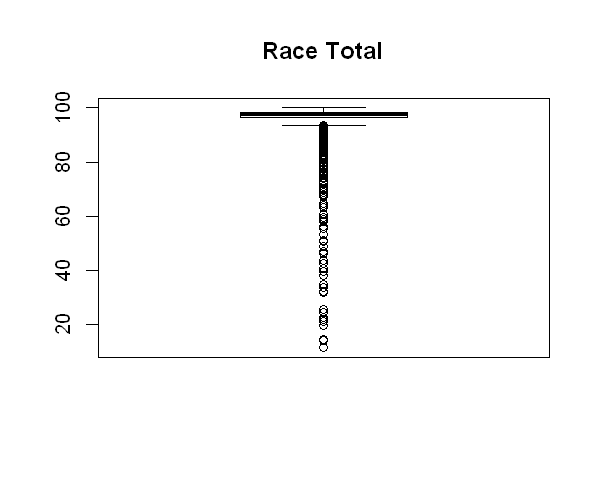

In [22]:
data$total_race <- data$PctAsian + data$PctBlack + data$PctWhite + data$PctOtherRace
message("The details of data for total race percentage is: ")
summary(data$total_race)
message("There are ",nrow(subset(data,data$total_race < 95)), " rows of data with total race percentage smaller than 95%")
message("There are ",nrow(subset(data,data$total_race < 50)), " rows of data with total race percentage smaller than 50%")
message("There are ",nrow(subset(data,data$total_race < 20)), " rows of data with total race percentage smaller than 20%")

boxplot(data$total_race, main = "Race Total")

When we look at the `MedianAge` column, we see some unreasonable high outliers. By examining the boxplot below, we found that values above 65 were nonsensical. These were assigned the `NA` value to be exlcuded from further analysis. This should not effect the analysis much, as these are only 31 values being removed (~1% total observations).

[1] 31

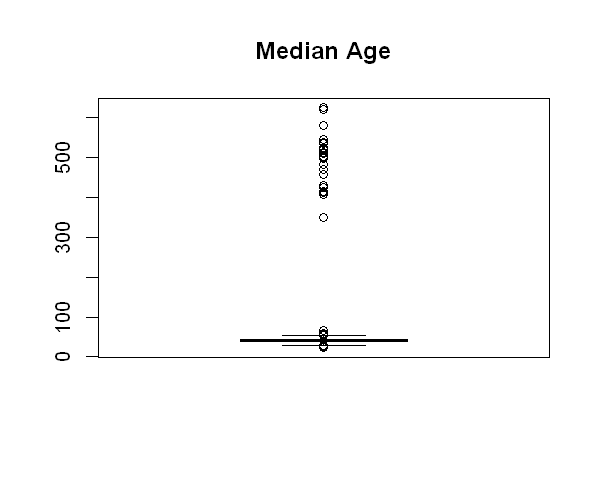

In [23]:
boxplot(data$MedianAge, main = "Median Age")

#filter out outliers
data$MedianAge[data$MedianAge > 65] <- NA
sum(is.na(data$MedianAge))

We also found that there are 61 instances of an Average Household Size being less than 1. While this may have some reasoning in real life such as secondary properties, there was no such documentation to confirm this. As such, we removed all values less than 1 since this does not make sense with our default assumptions that one person must live in a place for it to be considered a household. Again, this is a small amount of observations and should not effect many results in a major way.

[1] 61

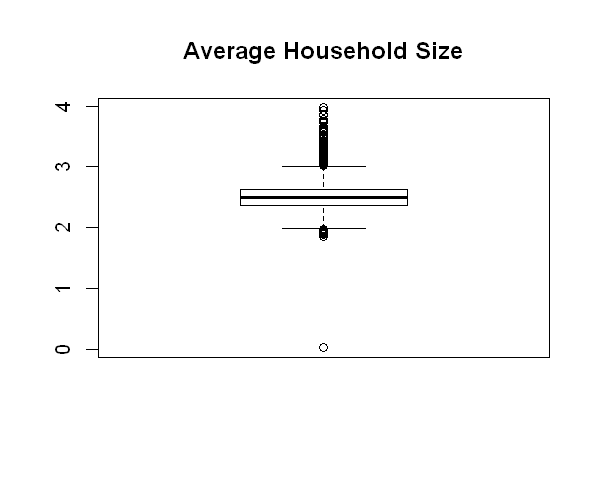

In [24]:
boxplot(data$AvgHouseholdSize, 
        main = "Average Household Size")

data$AvgHouseholdSize[data$AvgHouseholdSize < 1] <- NA
sum(is.na(data$AvgHouseholdSize))

We found one value where `PctHS18_24` was zero. In the US, it is difficult to believe that not one person in any given county has completed high school. We take away this value from further analysis. 

In [25]:
data$PctHS18_24[data$PctHS18_24 == 0] <- NA
sum(is.na(data$PctHS18_24))

[1] 1

The population data in `popEst2015` shows very heavy skew towards lower values, but the higher values also make sense for the hyper-urbanized areas such as Los Angeles, Chicago, New York, and the others that they represent. In this case, a log transformation could prove useful for further analysis to have a more uniform distribution of values.

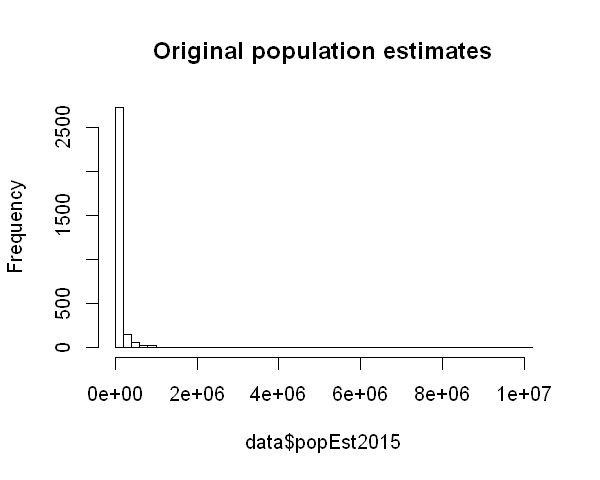

In [26]:
hist(data$popEst2015, , breaks = 50, main = "Original population estimates")

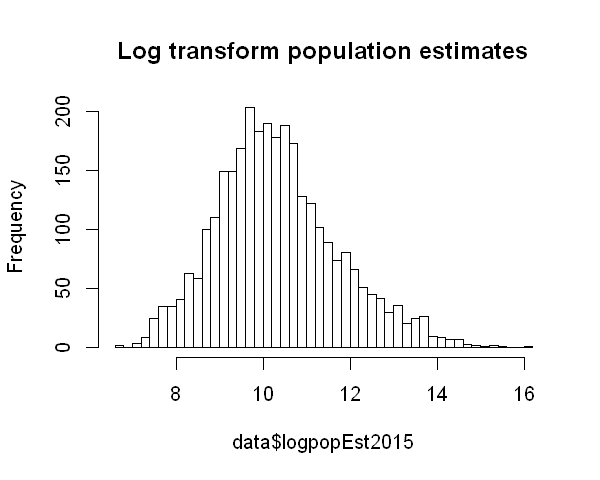

In [27]:
data$logpopEst2015 <- log(data$popEst2015)
hist(data$logpopEst2015, breaks = 50, main = "Log transform population estimates")

The last major item we have to address is the variables that are factors. The `binnedInc` column contains a categorical value for the bracket of the median income. Since this value is inherently contained by the `MedIncome` variable, we largely ignored this category since we can just as easily subset it on our own. There is another value that contains structured data in a string format in the `Geography` field, which gives the unique county for each observation. Individual counties are probably not so useful, but having the states as a factor to subset the data could prove useful.

In [28]:
#create the state column
data$Geography <- as.character(data$Geography)
split.geo <- strsplit(as.character(data$Geography), ", ")
states <- sapply(split.geo, 
                 function(x){
                   return(x[2])
                   })
data$state <- as.factor(states)
sample(data$state, 5)

[1] Montana Florida Texas   Texas   Indiana
51 Levels: Alabama Alaska Arizona Arkansas California Colorado ... Wyoming

## Exploratory Data Analysis

Given that our overall target is to better understand the death rate due to cancer, it probably makes most sense to look at this variable first. We see that it appears to follow more or less of a Gaussian curve _(note: refraining from implenting tests for normality until they are covered in course material)._ 

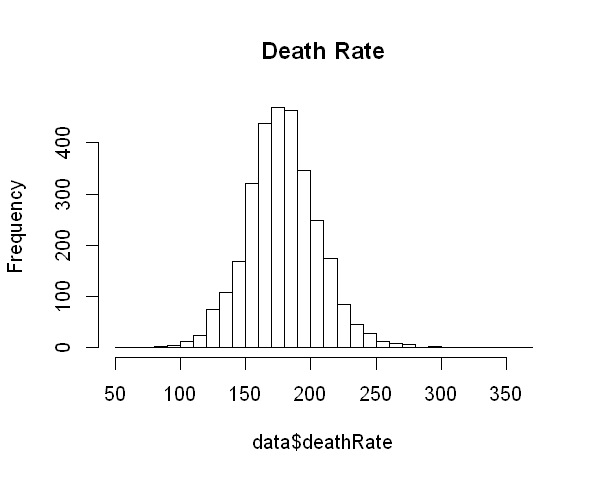

In [29]:
hist(data$deathRate, breaks = 40, main = "Death Rate")

To give guidance into what relationships in our data might be more interesting than others, we used the `corrplot` function from the `corrplot` package. This gives a visualization of the strength of the Pearson corrlation between various parameters. We note that we used a specific setting to only include values in which both observations were defined in calculating the Pearson coefficient (any `NA` values excluded). In this graphic, color <font color=blue>__blue__</font> represents positive correlation factor while color <font color=red>__red__</font> represents negative correlation. White indicates there is no clear correlation between the variables.

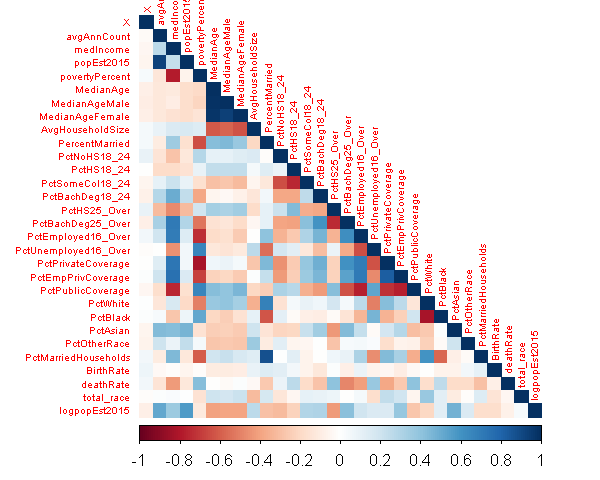

In [30]:
# only include numerical columns in correlation matrix
numeric.cols <- as.logical(unlist(lapply(data, is.numeric)))
corr.matrix <- cor(data[,numeric.cols], use = "pairwise.complete.obs")

corrplot(corr.matrix, is.corr=T , 
         method = "color", 
         type='lower',
         tl.cex = 0.5)

When looking at the corrplot, it is important to note that the colors only correspond to purely linear correlations in the data. If there are dynamics other than simple linear relationships, they may not have proper coloring to indicate that they are truly correlated. An example of this is to look at the difference in coloring of the `logpopEst2015` vs. `popEst2015`. The log transformed version of the data has stronger relationships with most variables, which indicates this might be a more useful variable to work with. In general, the `scatterplotMatrix` function from the `cor` package will give us better functionality to look at the distributions and relationships between a smaller amount of variables, but the above graphic allows for a better global view.

There are many "sanity checks" that we can gain from our data by looking at the corrplot. For instance, `medIncome` and `povertyPercent` are strongly negatively correlated. All of our parameters dealing with insurance make intuitive sense- the more public coverage, the less private coverage since people likely do not have 2 separate insurance plans. `PercentMattied` and `PctMarriedHouseholds` have a strong positive correlation, which seems logical. With sanity checks like these, we can ensure that parts of our data reflect reality.

Some interesting associations that are worth noting include the extremely high negative corrlation between `PctWhite` and `PctBlack`. While it makes sense these should be negatively correlated since they are different components of a whole, they show a much stronger relationship than any other two races. Additionally, the higher poverty rate areas and higher marriage percentage areas tend to have a higher percentage of black population and a lower percentage of whites. This shows some strong indication that segregation is prevalent in the counties in our dataset. In a different part of our data, education past a bachelor level is strongly correlated with both employment and private insurance coverage. Conversely, high poverty levels tend to be associated with higher public coverage, higher unemployment, and less bachelor-level education. 

Our target variable, `deathRate`, appears to have some interesting correlations that should warrant further investigation. For positive correlations,  `povertyPercent`, `PctHS25_Over`, `PctUnemployed16_Over`, and `PctPublicCoverage` appear to be important. For negative correlations, `medIncome`, `PctBachDeg25_Over`, and `PctEmployed16_Over` all seem important. Since ideally `PctEmployed16_Over` and `PctUnemployed16_Over` essentially tell the same information, we can look at only one of these. Even though they are less strong than the others mentioned, the insurance variables show that more public coverage tends to be associated with higher death rates, and more private coverage (whether through employers or self-bought) tends to be associated with lower death rates.

#### Subsetting of the high death rate counties

For further exploratory analysis, we want to define what constitutes a high death rate. We do this by using the upper bound inter-quartile range.

In [32]:
deathRatequrt3 <- quantile(data$deathRate, 0.75, na.rm=T)

data.higher <- subset(data, data$deathRate > deathRatequrt3)
print(paste0("There are ", nrow(data.higher), " observations in the highest quartile."))
print(paste0("The cutoff value is ", deathRatequrt3))

data.lower <- subset(data, data$deathRate < deathRatequrt3)

[1] "There are 761 observations in the highest quartile."
[1] "The cutoff value is 195.2"


We now look into the geography of the of the now-defined high death rate counties. From a boxplot, we see that the death rate varies state by state. A more detailed approach shows that the higher death rate states tend to be in the south, and Kentucky has the most high death rate counties by a wide margin.

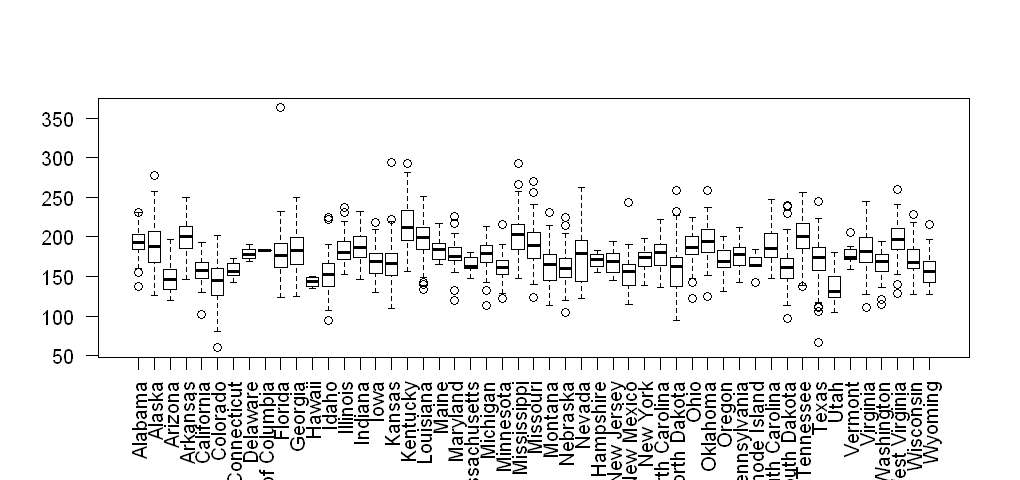

In [63]:
options(repr.plot.width=8.5, repr.plot.height=4) # let this plot be wider
boxplot(deathRate~state, data = data, las = 2)
options(repr.plot.width=5, repr.plot.height=4) # set back to default settings

In [47]:
state.summ <- data.frame(summary(data$state))
names(state.summ) <- c("Counties_total")

# group with higher death rate
state.summ1 <- data.frame(summary(data.higher$state))
names(state.summ1) <- c("Counties_total")

state.summ$Counties_highDeathRate <- state.summ1$Counties_total

# Percentage of counties with higher death reate for each state
state.summ$Counties_HDR_Perc <- state.summ$Counties_highDeathRate/state.summ$Counties_total

head(state.summ[order(state.summ$Counties_HDR_Perc, decreasing = TRUE),])

,Counties_total,Counties_highDeathRate,Counties_HDR_Perc
Kentucky,120,91,0.7583333
Tennessee,95,57,0.6000000
Louisiana,64,38,0.5937500
Arkansas,75,44,0.5866667
Mississippi,82,47,0.5731707
West Virginia,55,28,0.5090909


The analysis above shows that higher death rates cross state lines, but tend to stay below the Mason-Dixon line. Kentucky seems to be in a group of its own, with roughly 76% of its counties in the high death rate range. The other high death rate states are bunched closer to the 50-60% range, so Kentucky stands out and warrants further analysis. A quick google search shows that Kentucky particularly has high rates of obesity and smoking along with a lack of screening. Further research into this could provide additional insight, but is outside of the scope of the data given for this report.

We now shift our focus to exploring if raw numbers of cancer incidents correspond to higher rates of cancer deaths. We use a state-wide aggregation approach to look at the ratio of cancer incidents to the total population, and see how these correspond to the death rate in the state.

In [59]:
sum_incdt <- data.frame(aggregate(data$avgAnnCount, by=list(Category=data$state),FUN=sum))
names(sum_incdt) <- c("state","total_incident")
sum_incdt <- setDT(sum_incdt, keep.rownames = TRUE)[]
# tail(sum_incdt[order(sum_incdt$total_incident)],20)

#add the total population of state and the incident ratio
sum_pop <- data.frame(aggregate(data$popEst2015, by=list(Category=data$state),FUN=sum))
sum_incdt$popEst <- sum_pop$x
sum_incdt$incdtRatio <- sum_incdt$total_incident/sum_incdt$popEst

# average state-wide death rate
sum_deathRate <- data.frame(aggregate(data$deathRate, by=list(Category=data$state),mean))
sum_incdt$avgDeathRate <- sum_deathRate$x

head(sum_incdt[order(sum_incdt$incdtRatio, decreasing = TRUE),], 10)



rn,state,total_incident,popEst,incdtRatio,avgDeathRate
17,Kansas,200192.10,2831088,0.070712074,167.8343
24,Minnesota,170752.09,5489594,0.031104684,161.4816
29,Nevada,33365.35,2890845,0.011541729,177.4353
20,Maine,8214.00,1329328,0.006179062,183.1500
49,West Virginia,11130.00,1844128,0.006035373,196.7109
39,Pennsylvania,75909.00,12802503,0.005929231,175.4224
30,New Hampshire,7561.00,1330608,0.005682365,170.8800
46,Vermont,3548.00,626042,0.005667351,176.2714
7,Connecticut,20304.00,3590886,0.005654315,157.7125
18,Kentucky,24765.00,4425092,0.005596494,215.3158


In [60]:
cor(sum_incdt[,c(5, 6)])

,incdtRatio,avgDeathRate
incdtRatio,1.00000000,-0.06621098
avgDeathRate,-0.06621098,1.00000000


Had cancer incidents been strongly related to cancer deaths, we would have expected to see Kentucky closer to the top of this list. We see that the correlation coefficient is close to zero, which shows that this relationship is not so strong. This was also seen in the corrplot earlier in the report. This suggests that the relationship between incidents and deaths is not the strongest factor at play and may not be the correct area to focus on for policy recommendation.

We now shift our focus to measures of treatment. In our dataset, this is best seen through the insurance parameters. In general, we would expect to see that higher percentages of private insurance plans would correspond to better treatment and therefore fewer cancer deaths.

In [ ]:
# add to the table above with insurance coverage
# average private coverage by state
sum_PriCov <- data.frame(aggregate(data$PctPrivateCoverage, by=list(Category=data$state),mean))

# average private employed coverage by state
sum_PriEmCov <- data.frame(aggregate(data$PctEmpPrivCoverage, by=list(Category=data$state),mean))
# average public coverage by state
sum_PubCov <- data.frame(aggregate(data$PctPublicCoverage, by=list(Category=data$state),mean))

sum_incdt$Private_Co <- sum_PriCov$x
sum_incdt$PriEm_Co <- sum_PriEmCov$x
sum_incdt$Pub_Co <- sum_PubCov$x

# head(sum_incdt[order(sum_incdt$Private_Co)],10)
# head(sum_incdt[order(sum_incdt$PriEm_Co)],10)
# tail(sum_incdt[order(sum_incdt$Pub_Co)],10)
message("Private Converage")
summary(sum_incdt$Private_Co)
message("Private Employer coverage")
summary(sum_incdt$PriEm_Co)
message("Public Converage")
summary(sum_incdt$Pub_Co)
tail(sum_incdt[order(sum_incdt$avgDeathRate)],10)
head(sum_incdt[order(sum_incdt$avgDeathRate)],5)
